In [7]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,f1_score

In [8]:
def split(data, test_data, drop):
    X_train = data.copy()
    y_train = X_train.pop('target')
    X_test = test_data.copy()
    y_test = X_test.pop('target')

    X_train = X_train[y_train != drop]
    X_test = X_test[y_test != drop]

    y_train = y_train[y_train != drop]
    y_test = y_test[y_test != drop]

    std = StandardScaler()
    std.fit(X_train)
    X_train = pd.DataFrame(std.transform(X_train), columns = X_train.columns, index = X_train.index)
    X_test = pd.DataFrame(std.transform(X_test), columns = X_test.columns, index = X_test.index)
    return X_train, y_train, X_test, y_test, std

In [9]:
def train_test(model, X_train, y_train, X_test, y_test):
    model = model.fit(X_train, y_train)
    y_pred = pd.Series(model.predict(X_test),index=y_test.index)
    return model, y_pred

In [10]:
data = pd.read_csv('dataset/train.csv', index_col='name')
test_data = pd.read_csv('dataset/test.csv', index_col='name')

In [11]:
%%time
models = {
    "Random Forest": RandomForestClassifier(
                    random_state=42,
                    max_features='auto',
                    n_estimators= 500,
                    max_depth=6,
                    criterion='entropy',),
    "ANN": MLPClassifier(
                    max_iter=600,
                    momentum=0.6,
                    solver='adam',
                    activation='relu',
                    learning_rate_init=0.005,
                    alpha=0.001,
                    random_state=42),
    "SVM": svm.SVC(random_state=42),
    "Decision Tree": DecisionTreeClassifier(
                    random_state = 42,
                    criterion = 'entropy',
                    max_depth = 2,
                    max_features = 'log2',
                    splitter = 'best',),
    "KNN": KNeighborsClassifier(
                    algorithm='auto',
                    leaf_size=30,
                    metric='minkowski',
                    metric_params=None,
                    n_jobs=10,
                    n_neighbors=2,
                    p=3,
                    weights='uniform'),
}
classes = ['normal', 'fatty', 'cirrhosis']

for drop in classes:
    results = pd.DataFrame()
    X_train, y_train, X_test, y_test, std = split(data, test_data, drop)
    classes = np.unique(y_train)
    for col in X_train.columns:
        temp = {}
#         print(*[cls for cls in classes if cls != drop])
        for name in models.keys():
            model, y_pred = train_test(models[name], X_train[col].values.reshape(-1, 1), y_train, X_test[col].values.reshape(-1, 1), y_test)
#             print(name," Accuracy: ",accuracy_score(y_pred,y_test))
            temp[f"{name} Accuracy"] = accuracy_score(y_pred,y_test)
#         print('\n\n')
        results = results.append(pd.DataFrame(temp,index=[col]))
    results.to_excel(f"dataset/manual selection/random/{classes[0]}_{classes[1]}.xlsx")

Wall time: 5min 53s


## Visualization

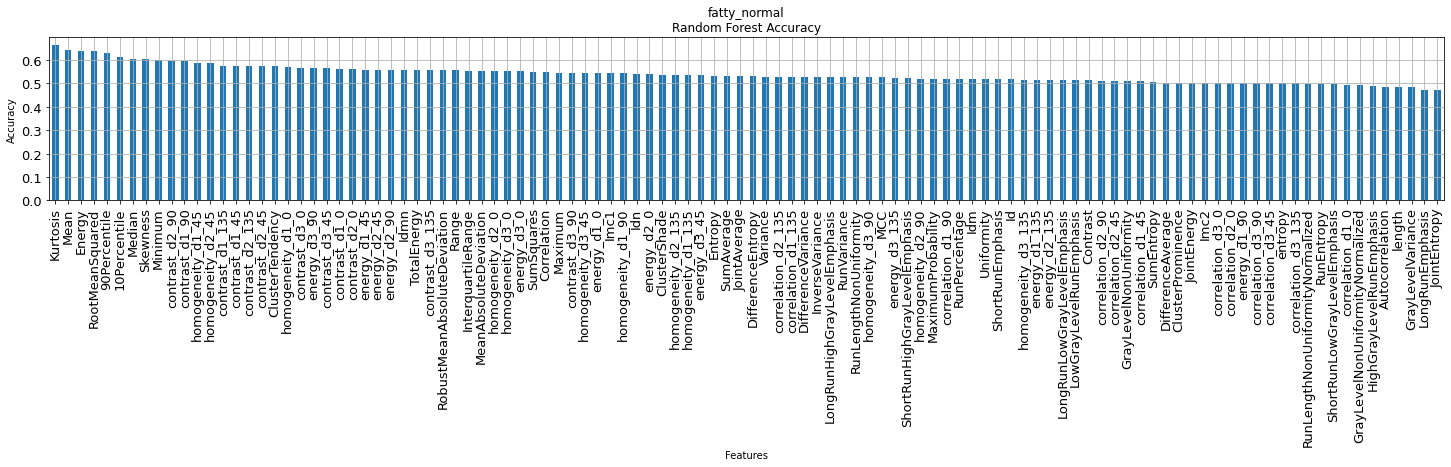

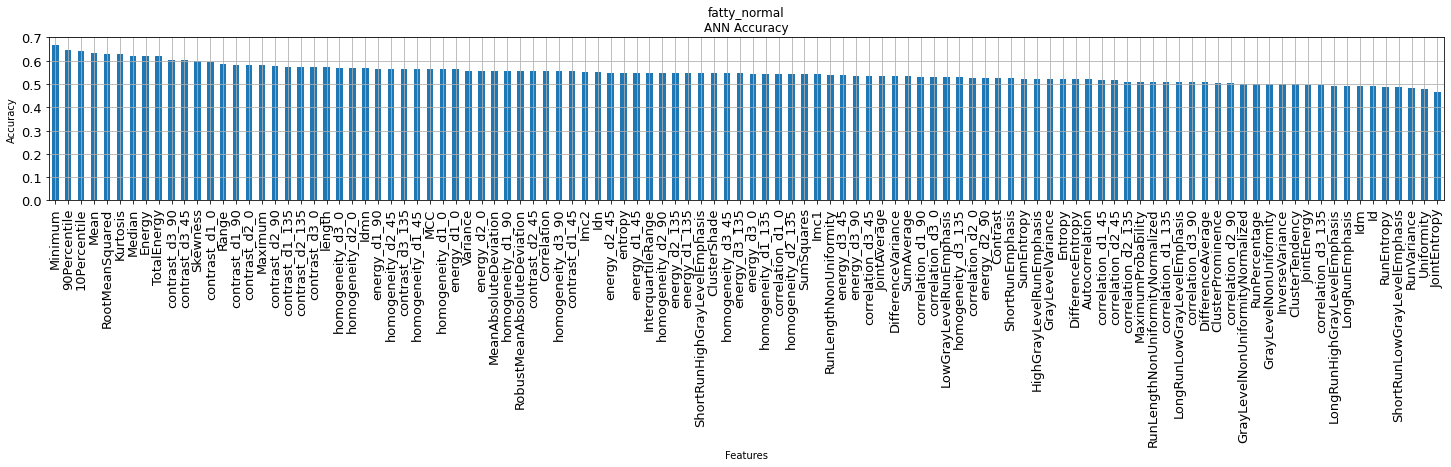

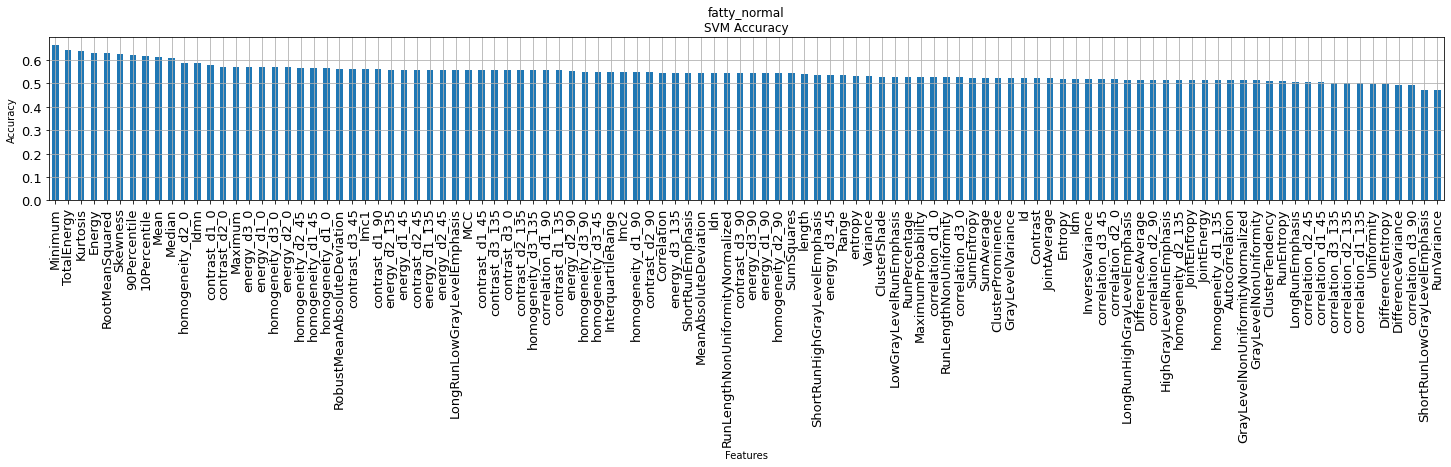

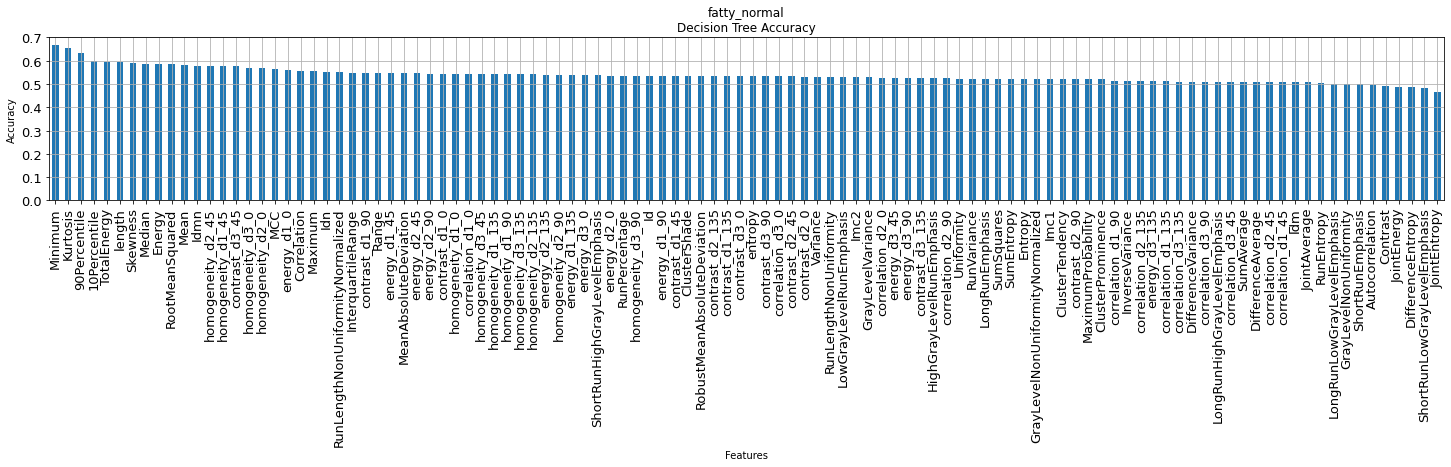

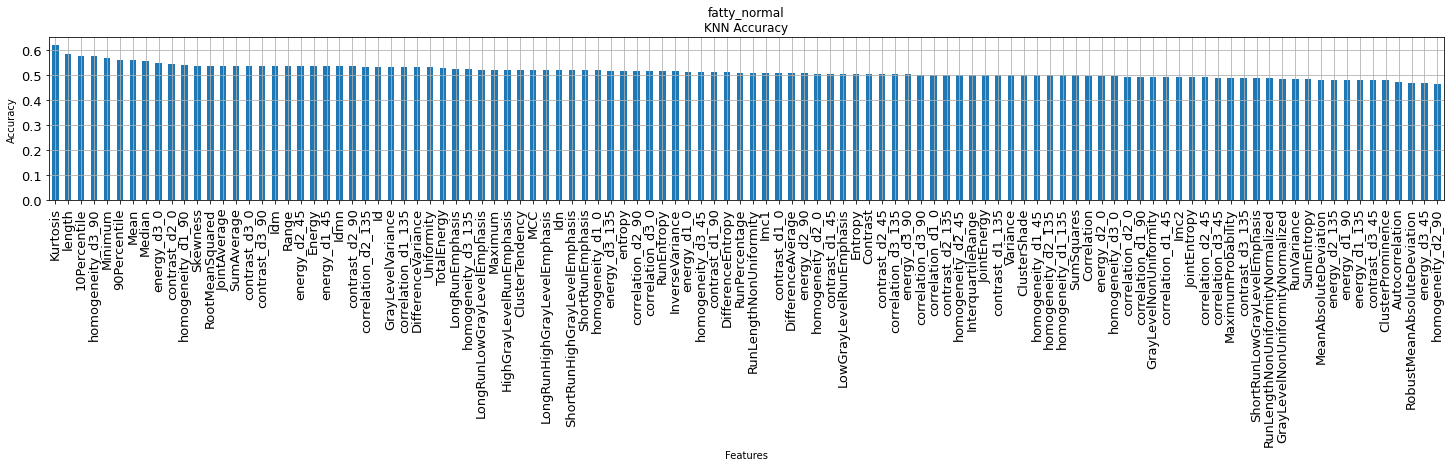



___________________________________________________________________________________________________________________




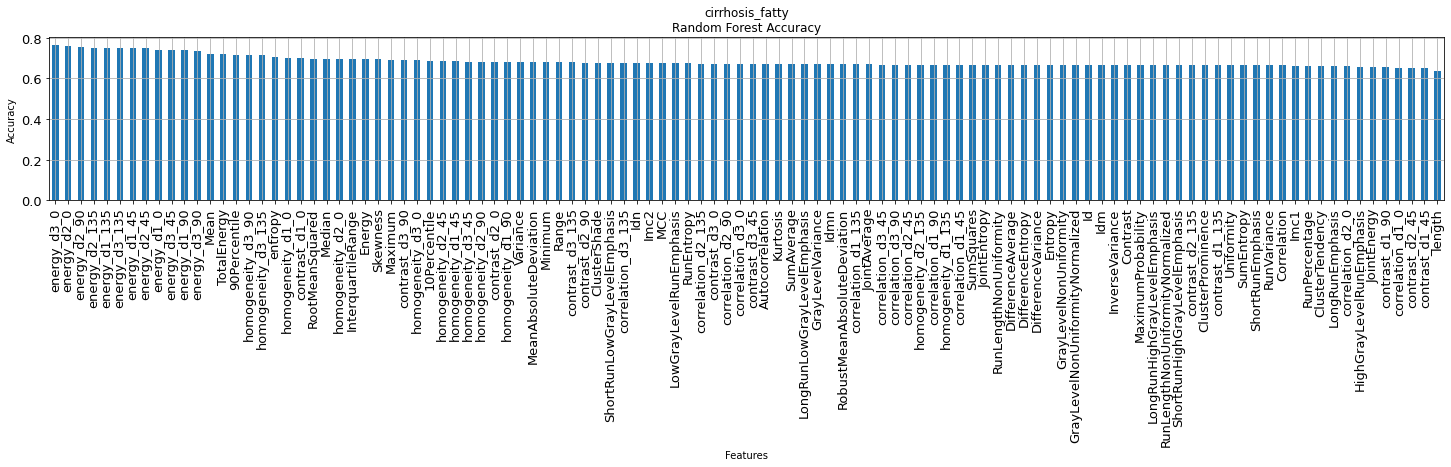

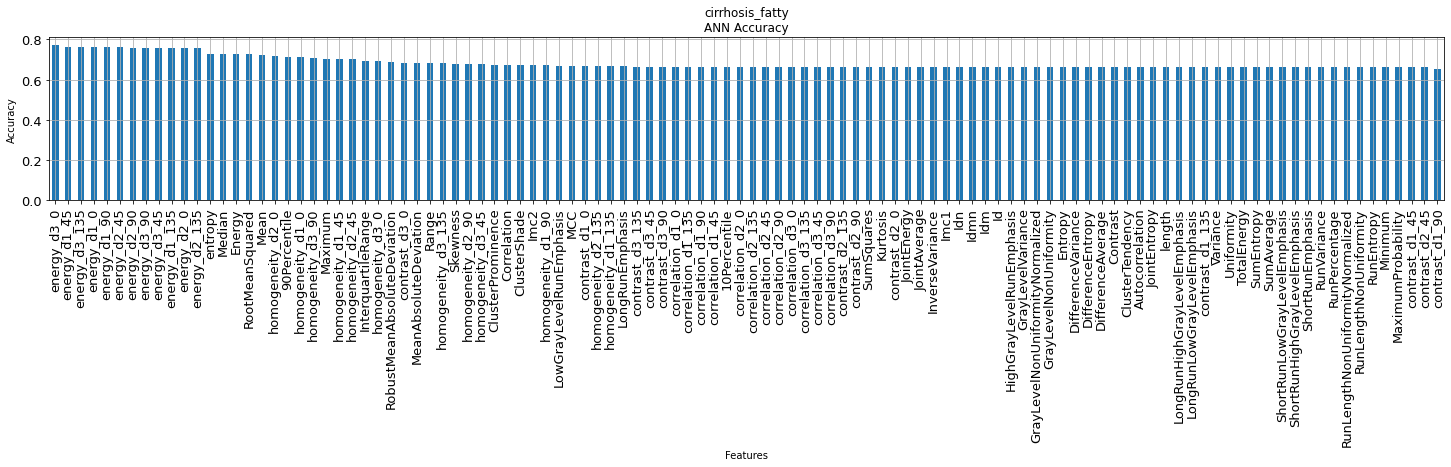

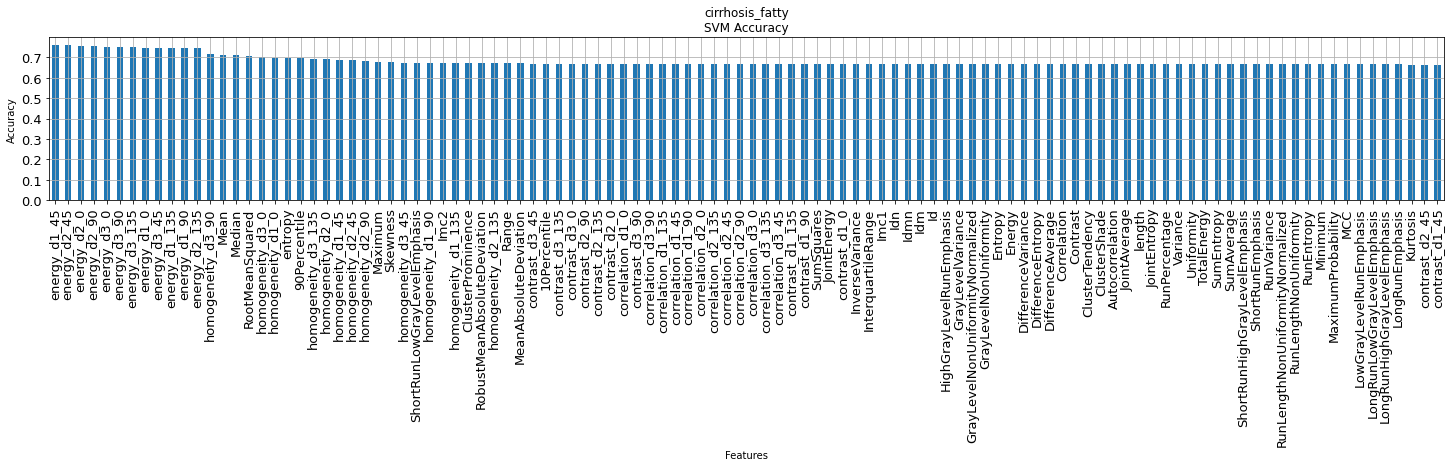

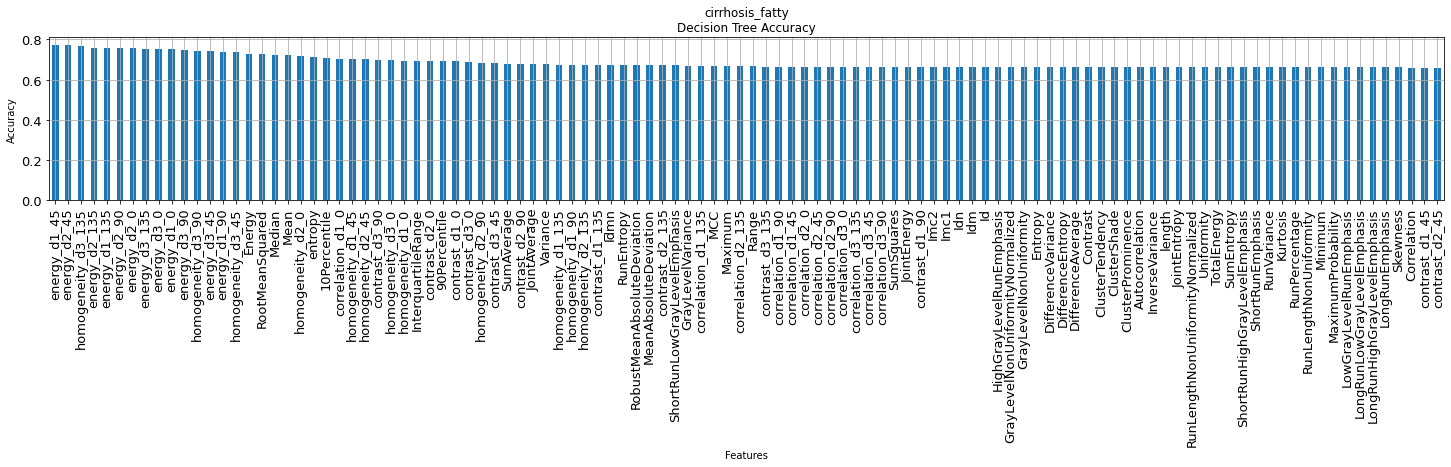

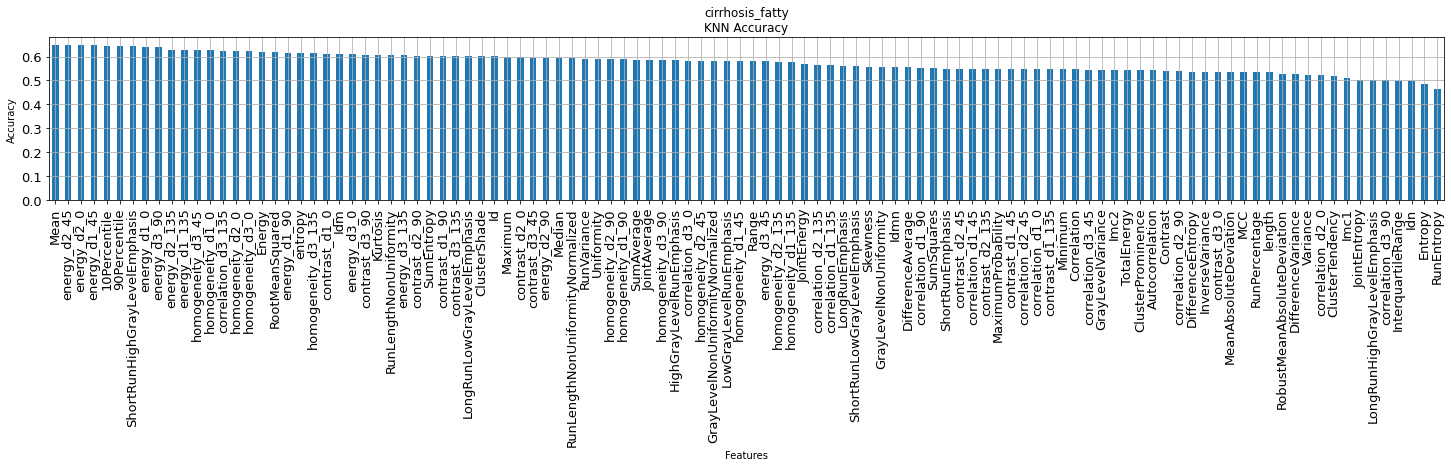



___________________________________________________________________________________________________________________




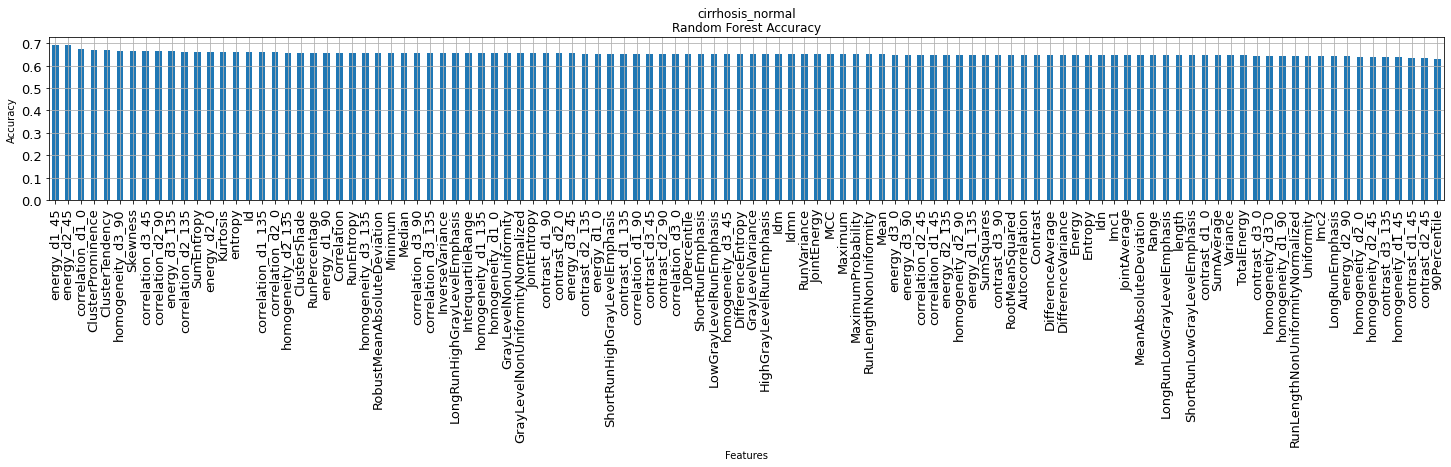

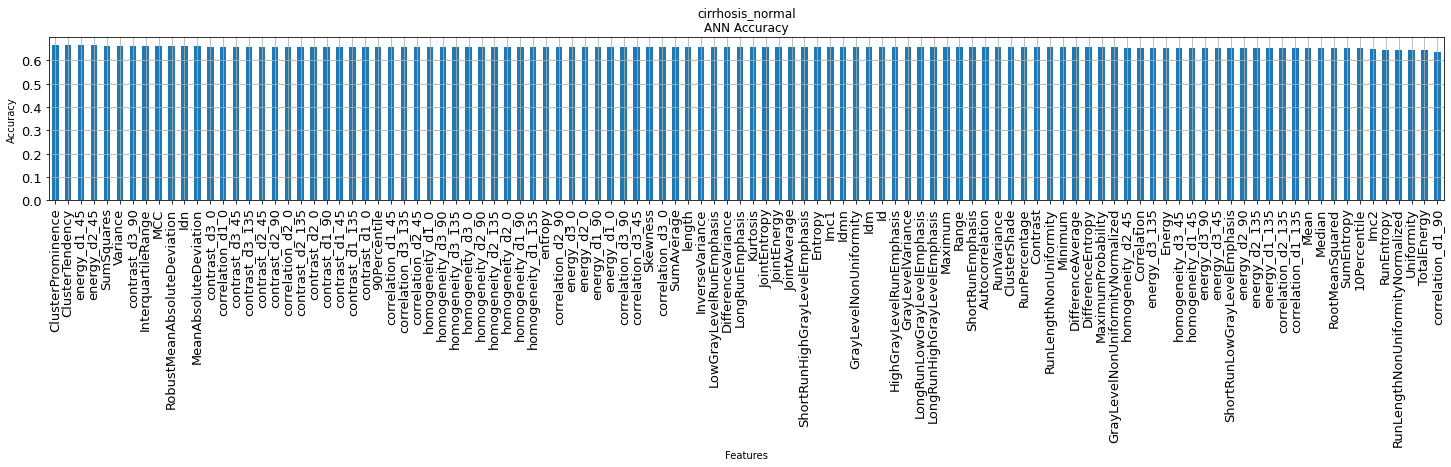

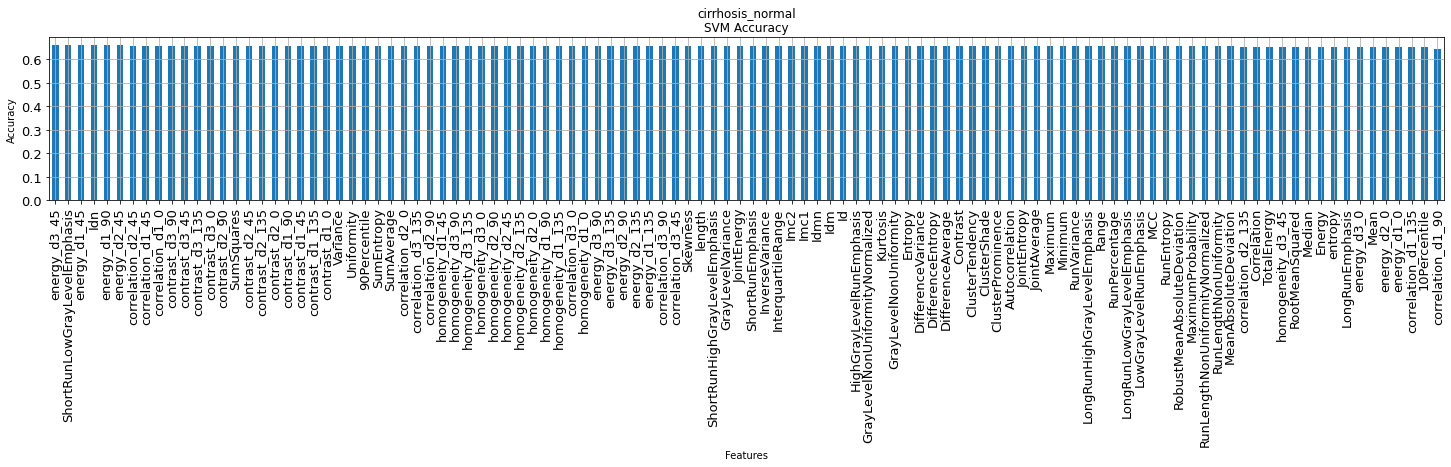

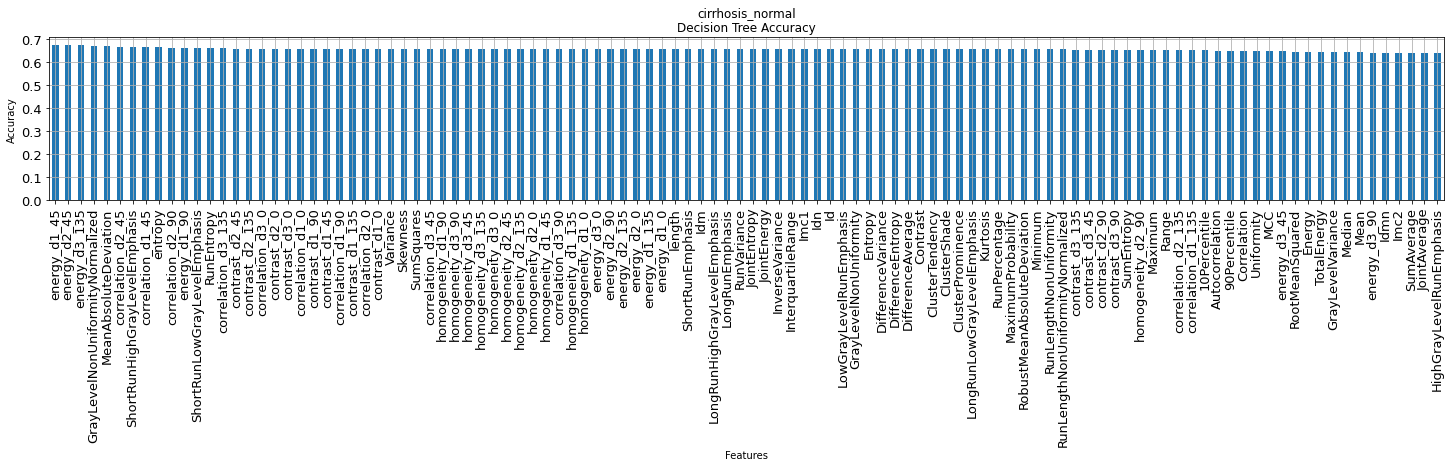

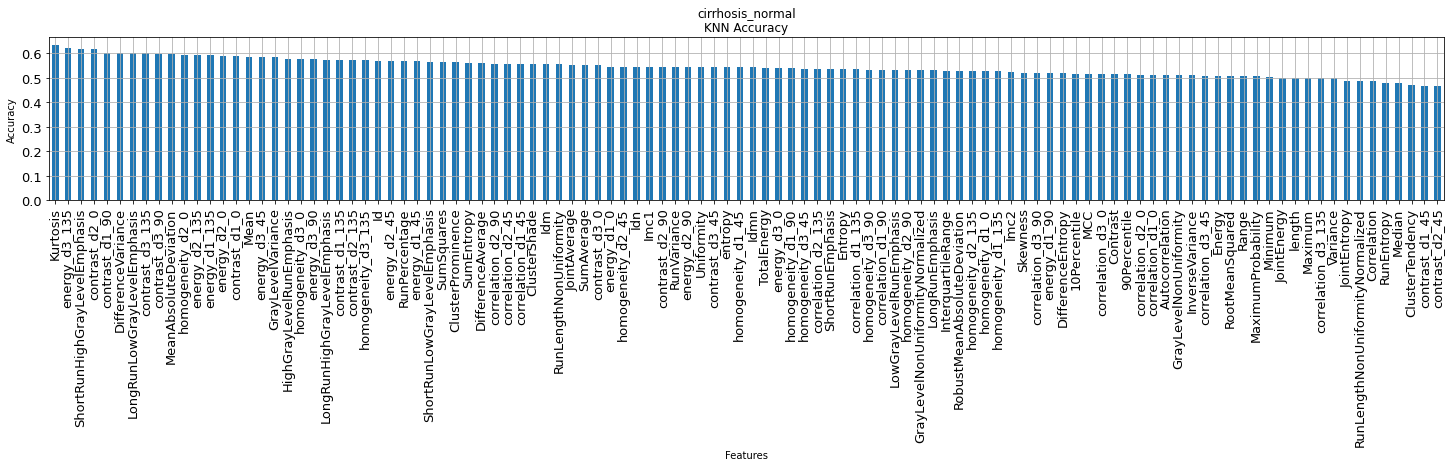



___________________________________________________________________________________________________________________




In [12]:
files = ['fatty_normal', 'cirrhosis_fatty', 'cirrhosis_normal']
for name in files:
    data = pd.read_excel(f'dataset/manual selection/random/{name}.xlsx', index_col = 0)
    for col in data.columns:
        model_accuracy = data[col].copy()
        model_accuracy.sort_values(ascending=False, inplace=True)
        model_accuracy.plot(title=f'{name}\n{col}',xlabel='Features',ylabel="Accuracy",kind="bar", legend=False, figsize=(25,3), fontsize=13, grid=True)
        plt.show()
    print('\n\n___________________________________________________________________________________________________________________\n\n')

## Selection

In [13]:
files = ['fatty_normal', 'cirrhosis_fatty', 'cirrhosis_normal']
features_acc={}
for name in files:
    features_acc[name] = pd.read_excel(f'dataset/manual selection/random/{name}.xlsx', index_col = 0)

In [14]:
data = pd.read_csv('dataset/train.csv', index_col='name')
test_data = pd.read_csv('dataset/test.csv', index_col='name')

In [15]:
%%time
models = {
    "Random Forest": RandomForestClassifier(
                    random_state=42,
                    max_features='auto',
                    n_estimators= 500,
                    max_depth=6,
                    criterion='entropy',),
    "ANN": MLPClassifier(
                    max_iter=600,
                    momentum=0.6,
                    solver='adam',
                    activation='relu',
                    learning_rate_init=0.005,
                    alpha=0.001,
                    random_state=42),
    "SVM": svm.SVC(random_state=42),
    "Decision Tree": DecisionTreeClassifier(
                    random_state = 42,
                    criterion = 'entropy',
                    max_depth = 2,
                    max_features = 'log2',
                    splitter = 'best',),
    "KNN": KNeighborsClassifier(
                    algorithm='auto',
                    leaf_size=30,
                    metric='minkowski',
                    metric_params=None,
                    n_jobs=10,
                    n_neighbors=2,
                    p=3,
                    weights='uniform'),
}
classes = ['normal', 'fatty', 'cirrhosis']


result = {col:pd.DataFrame() for col in features_acc.keys()}
for classifier in features_acc.keys():
    keep = classifier.split('_')
    drop = [cls for cls in classes if cls not in keep]
    X_train, y_train, X_test, y_test, std = split(data, test_data, drop[0])
    print("Classifier: ", classifier)
    for model_acc in features_acc[classifier].columns:
        feat_imp = features_acc[classifier][model_acc].sort_values(ascending=False)
        model_name = model_acc[:len(model_acc) - 9]
        res = pd.DataFrame(columns=[model_name])
        for i in range(2,108):
            cols = feat_imp.index[0:i]
            model, y_pred = train_test(models[model_name], X_train[cols], y_train, X_test[cols], y_test)
            res.loc[i] = {model_name: accuracy_score(y_pred,y_test)}
        print(model_name)
        result[classifier] = pd.concat([result[classifier], res], axis=1)

Classifier:  fatty_normal
Random Forest
ANN
SVM
Decision Tree
KNN
Classifier:  cirrhosis_fatty
Random Forest
ANN
SVM
Decision Tree
KNN
Classifier:  cirrhosis_normal
Random Forest
ANN
SVM
Decision Tree
KNN
Wall time: 14min 37s


In [16]:
for name in result.keys():
    result[name].to_excel(f"dataset/manual selection/random/model acc/{name}.xlsx")

In [17]:
for key in features_acc.keys():
    print(name)
    for model_acc in features_acc[key].columns:
        print(model_acc)
        feat_imp = features_acc[key][model_acc].copy()
        feat_imp.sort_values(ascending=False,inplace=True)
        for i,j in zip(feat_imp[0:9],feat_imp.index[0:9]):
            print('\t',j,': ',i)

cirrhosis_normal
Random Forest Accuracy
	 Kurtosis :  0.6644736842105263
	 Mean :  0.6414473684210527
	 Energy :  0.6381578947368421
	 RootMeanSquared :  0.6381578947368421
	 90Percentile :  0.6282894736842105
	 10Percentile :  0.6151315789473685
	 Median :  0.6052631578947368
	 Skewness :  0.6052631578947368
	 Minimum :  0.6019736842105263
ANN Accuracy
	 Minimum :  0.6677631578947368
	 90Percentile :  0.6480263157894737
	 10Percentile :  0.6414473684210527
	 Mean :  0.631578947368421
	 RootMeanSquared :  0.6282894736842105
	 Kurtosis :  0.6282894736842105
	 Median :  0.6217105263157895
	 Energy :  0.6217105263157895
	 TotalEnergy :  0.618421052631579
SVM Accuracy
	 Minimum :  0.6644736842105263
	 TotalEnergy :  0.6414473684210527
	 Kurtosis :  0.6381578947368421
	 Energy :  0.6282894736842105
	 RootMeanSquared :  0.6282894736842105
	 Skewness :  0.625
	 90Percentile :  0.6217105263157895
	 10Percentile :  0.618421052631579
	 Mean :  0.6151315789473685
Decision Tree Accuracy
	 Minimum 